In [1]:
%gui osx
# %matplotlib inline # doesn't work for John
import random as rand
import pygame as pg

from genelife import *

pygame 1.9.5.dev0
Hello from the pygame community. https://www.pygame.org/contribute.html


## Graphics notes

This notebook uses the pygame interface.

It pops up a pygame window (labeled "Gene Life"), which must be moved to the side to see the notebook.

To stop the simulation mid-stream, you can click on the pygame window, click in the window. 

Color is currently a 32 bit hash of the 64 bit gene value.

To change resolution: 
* change `subgenelife.c` line 23 (`log2N`) and rebuild c lib
* change `genlife.py` line 10 (also `log2N`)
* change `Width` and `Height` below.

## Initialization

See additional discussion in the [genelife wiki](https://github.com/js1200/genelife/wiki/Probability-parameters-in-genelife).

The code determining the effect of genes on birth, and the mutation of genomes is currently on lines 229-242 of `subgene.c`.

Parameter `rulemod` deterimines if genes are affecting the GOL dynamics at all.
* `rulemod == 0` => Genes have no affect; GOL dynamics prevail.  
* `rulemod == 1` => Genes alter GOL dynamics.

Parameter `repscheme` controls possible replication schemes for birth in the case of 3 live neighbours.  For 3 live neighbours, a unique one may be chosen deterministically in 2 ways:  (i) most different, and (ii) a particular nbr (0th) of a canonical rotation.  

Consider two cases, `repscheme bit 0 unset` and `repscheme bit 0 set`, and for each of these consider when `repscheme bit 1` is unset and set:

* `repscheme bit 0 unset`
    * `repscheme == 0` => use most different of the 3 live nbrs as ancestor
    * `repscheme == 2` => use 0th nbr of canonical rotation as ancestor
* `repscheme bit 0 set`
    * `repscheme == 1` => apply selection to complement pair of most different of the 3 live nbrs.
    * `repscheme == 3` => apply selection to complement pair of 0th nbr of canonical rotation

The `selection` parameter provides a choice between a variety of deterministic schemes to choose between two possible ancestors, either in the case of birth from 2 live neighbours or the two cases of birth from 3 live neighbours with `repscheme bit 0` set.
* `selection == 0` larger integer value determines survival
* `selection == 1` larger number of 1's 
* `selection == 2` paper-scissors-rock-well
* `selection == 3` selection based on closeness to one of the two difft targets (ncoding bits apart)
* `selection == 4` selection based on closeness of g0 to 0x0 and g1 to all 1's; for birth distances must satisfy `d0<ncoding`, `d1<ncoding`, and `dd=D(g0,g1) < ncoding.`  `ncoding>55` for any exceptions.
* `selection == 5` Predator prey: prey goes toward all 0's, predator goes toward all 1's.  N1(g)<32 => prey; birth if different and at least one prey; both prey => prey with less 1's wins, prey-predator => predator wins.

Parameter `nlog2pmut` fixes mutation probability.  `nlog2pmut` takes integer values, label them $k$; then  $p_{\rm mut} = 2^{-k}$

In [2]:
offsets = [[ 0, 0, 0],
           [-1,-1, 0],
           [ 0,-1, 0],
           [ 1,-1, 0],
           [ 1, 0, 0],
           [ 1, 1, 0],
           [ 0, 1, 0],
           [-1, 1, 0],
           [-1, 0, 0]]
numHis = pow(2,len(offsets))
histo=np.zeros(numHis,np.uint64)
flatoff =  [x for sublist in offsets for x in sublist]
npoffsets = np.array(flatoff,np.int32)

runparams = np.zeros(7,np.int32)
simparams = np.zeros(5,np.int32)    # 5 parameters passed to C

Following animation cell is set up to display for `ndisp` time steps, run without display for `nskip` time steps, and repeat, up to a total of `niter*ndisp` frames displayed (`niter*(ndisp+nskip)` total time steps):

|---`ndisp`---|------------------`nskip`---------------| ... repeated for `niter` times


In [3]:
Width = 512
Height = 512

screen = pg.display.set_mode([2*Width, 2*Height])
scr = pg.surface.Surface([Width,Height], 0)
#scr2 = pg.surface.Surface([Width*2,Height*2], 0)
cnt = 0
caption = "Gene Life at iteration %d" % cnt
pg.display.set_caption(caption)
pg.draw.rect(screen, [10, 10, 10],(0, 0 , Width, Height + 1), 0)
pg.transform.scale2x(scr,screen)  # Norman do you know how to do this?
pg.display.update()

cgrid = pg.surfarray.pixels2d(scr)

In [4]:
def update():
    global gol, cgrid
    global golg
    global log2N
    global runparams
    global cnt
    global framenr

    cnt = cnt+1
    if cnt % ndisp == 0:  # insert the non-displayed iterations & count species
        genelife.genelife_update(nskip, nhist, nstat)
        # genelife.countspecies(gol,golg)
        genelife.countspecieshash()
        framenr = framenr + nskip
    genelife.genelife_update(nrun, nhist, nstat)
    genelife.get_curgol(gol)
    genelife.get_curgolg(golg)
    framenr = framenr+nrun
    colorgrid()  # sets  cgrid
    #time_text.set_text('cnt = %.1d' % framenr)
    #time_text.set_color('w')
    return

# this function defined in genelife.py doesn't work in the notebook.
# must redefine it here.  Maybe scope of globals?
def colorgrid():
    """ colors array according to grid and genegrid using colormethod"""
    global gol,cgrid,golg,cgolg,N
    
    genelife.colorgenes(gol,golg,cgolg)
    for i in xrange(N):
        for j in xrange(N):
            ij = i+j*N
            cgrid[i,j] = cgolg[ij]
            # cgrid=np.reshape(cgolg,(N,N))   does not work, why ???????
    return


In [105]:
nrun=1; ndisp=100; nskip=0; niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0x40          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth only for asymmetric configs 
                                         # bit 6 on for gene encoded 1st neighbour masking
selection = runparams[2] = 7             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survival = runparams[4] = 3              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0(hash)or 1(fnal)
fileinit = runparams[6] = 0              # init via 32x32 genepat.dat

nlog2pmut = simparams[0] = 4             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 10000   # initial density of random genes
ncoding = simparams[3] = 12               # no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0


In [138]:
nrun=1; ndisp=100; nskip=900; niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0x40          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth only for asymmetric configs 
                                         # bit 6 on for gene encoded 1st neighbour masking
selection = runparams[2] = 5             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survival = runparams[4] = 3              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 0         # color function 0(hash)or 1(fnal)
fileinit = runparams[6] = 0              # init via 32x32 genepat.dat

nlog2pmut = simparams[0] = 6             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 1000   # initial density of random genes
ncoding = simparams[3] = 2               # no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0


In [139]:
# display initial population and count species
caption = "Gene Life at iteration %d" % framenr
pg.display.set_caption(caption)
genelife.get_curgol(gol)
genelife.get_curgolg(golg)
colorgrid()
pg.transform.scale2xact(scr,screen)  # use this for custom pygame no smoother    
pg.display.flip()
genelife.countspecieshash()

In [140]:
#single step and update display and species counts
update()
caption = "Gene Life at iteration %d" % framenr
pg.display.set_caption(caption)
genelife.get_curgol(gol)
genelife.get_curgolg(golg)
pg.transform.scale2xact(scr,screen)  # use this for custom pygame no smoother    
pg.display.flip()
genelife.countspecieshash()
# ipython.notebook.move_selection_up  # would like to reselect cell after execution

In [141]:
# infinite loop of display updates (click in graphics window to stop)
gogo = True
while gogo:
    for event in pg.event.get():
        if event.type==pg.QUIT:
            gogo = False
        if event.type==pg.MOUSEBUTTONDOWN:
            gogo = False
    update()
    caption = "Gene Life at iteration %d" % framenr
    pg.display.set_caption(caption)
    # pg.transform.scale2x(scr,screen)  # use this for pygame scale2x with smoother
    pg.transform.scale2xact(scr,screen)  # use this for custom pygame no smoother    
    pg.display.flip()

### Trace of number of live cell statistics

In [85]:
ntmax = 1024
while framenr//nstat > ntmax: ntmax = ntmax*2   # increase ntmax to next power of 2 to match C memory
tpts=np.zeros(ntmax,np.int32)
livestats = np.zeros(ntmax,np.int32)
genotypes = np.zeros(ntmax*4,np.int32)
genotypes4 = np.reshape(genotypes,(ntmax,4)).T
stepstats = np.zeros(ntmax*10,np.int32)
stepstats10 = np.reshape(stepstats,(ntmax,10)).T

ZeroDivisionError: integer division or modulo by zero

In [38]:
nt = framenr//nstat
genelife.get_stats(livestats,genotypes,stepstats,nt)
tpts = [i*nstat for i in range(1,nt)]

ZeroDivisionError: integer division or modulo by zero

In [ ]:
for i in range(20):
    print tpts[i]

In [ ]:
%matplotlib inline
# fig, ax = plt.subplots()
plt.rcParams['figure.figsize'] = [10, 10]
f, (ax1, ax2) = plt.subplots(2, sharex=True, sharey=False)
ax1.plot(tpts,stepstats10[0][1:nt],'b',label='notgolrul')
ax1.plot(tpts,stepstats10[1][1:nt],'g',label='2_live')
ax1.plot(tpts,stepstats10[2][1:nt],'r',label='3_live')
ax1.plot(tpts,stepstats10[3][1:nt],'c',label='birth')
ax1.plot(tpts,stepstats10[4][1:nt],'m',label='mutation')
ax1.plot(tpts,stepstats10[5][1:nt],'b--',label='2select')
ax1.plot(tpts,stepstats10[6][1:nt],'g--',label='survival')
ax1.plot(tpts,stepstats10[7][1:nt],'r--',label='death')
ax1.plot(tpts,stepstats10[8][1:nt],'k--',label='golstate')
ax1.plot(tpts,stepstats10[9][1:nt],'m--',label='3g_same')
ax2.plot(tpts,genotypes4[0][1:nt],'b',label='d=0 class')
ax2.plot(tpts,genotypes4[1][1:nt],'g',label='d=1 class')
ax2.plot(tpts,genotypes4[2][1:nt],'r',label='d=2 class')
ax2.plot(tpts,genotypes4[3][1:nt],'k',label='d=3 class')
ax1.set_ylabel('number of such cells')
ax2.set_ylabel('number of such cells')
legend1 = ax1.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')  # or use  loc = 'best'
legend2 = ax2.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')
legend1.get_frame().set_facecolor('C0')
legend2.get_frame().set_facecolor('C0')
plt.show()

### Space-time of one row

In [99]:
genelife.get_curgol(gol)
cnt = range(512)
for i in range(512):
    cnt[i] = sum([gol[(i*512)+j] for j in range(512)])

In [100]:
foo = [(i,cnt[i]) for i in range(512) if cnt[i] == max(cnt)]
foo

[(505, 84.0)]

In [101]:
myrow = foo[0][0]
for i in range(512):
    genelife.get_curgol(gol)
    for j in range(512):
        if gol[(512*myrow)+j]==1:
            cgrid[i][j] = 1
        else:
            cgrid[i][j] = 0
    genelife.genelife_update(1,0,0)
    

In [102]:
%matplotlib inline

Number of labels: 257


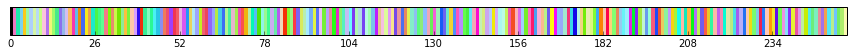

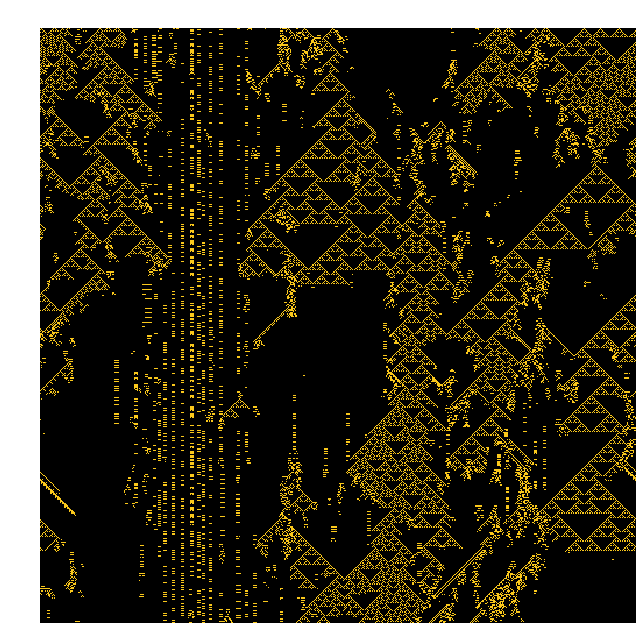

In [103]:
my_dpi=96
my_cmap = rand_cmap(257, type='bright', first_color_black=True, last_color_black=False)

fig, ax = plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
ax.axis('off')
# mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
mat = ax.matshow(cgrid, cmap=my_cmap, vmin = 0, vmax = 56)
plt.show()